In [1]:
loan <- read.csv("loan.csv", stringsAsFactors = FALSE)
loanT <- loan

In [2]:
num.NA <- sort(sapply(loan, function(x) {sum(is.na(x))}), decreasing=TRUE)

In [3]:
remain.col <- names(num.NA)[which(num.NA <= 0.8 * dim(loan)[1])]

In [4]:
t.test(int_rate ~ term, data = loan)


	Welch Two Sample t-test

data:  int_rate by term
t = -431.12, df = 467040, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.111525 -4.074310
sample estimates:
mean in group  36 months mean in group  60 months 
                12.01868                 16.11160 


In [5]:
# How to calculate the stats by hand
short_term <- subset(loan, term == ' 36 months')
long_term <- subset(loan, term == ' 60 months')

In [6]:
stderr <- sqrt(var(short_term$int_rate) / dim(short_term)[1] +
                 var(long_term$int_rate) / dim(long_term)[1])
t.score <- (mean(short_term$int_rate) - mean(long_term$int_rate)) / stderr
p.val <- 2 * pt(t.score, df = 467040)

In [7]:
# understand chi-square test
# Check if grade and term are independent, what's null hypo and alternative hypo here?
round(with(loan, table(term, grade)) / as.numeric(table(loan$term)), 2)
with(loan, chisq.test(grade, term))
# p value
1 - pchisq(176070, df=6)

            grade
term            A    B    C    D    E    F    G
   36 months 0.23 0.34 0.26 0.12 0.04 0.01 0.00
   60 months 0.02 0.16 0.31 0.24 0.18 0.07 0.02


	Pearson's Chi-squared test

data:  grade and term
X-squared = 176070, df = 6, p-value < 2.2e-16


[1] 0

In [8]:
apply(with(loan, table(term, grade)), 1, sum) # row sum
apply(with(loan, table(term, grade)), 2, sum) # col sum

36 months  60 months 
    621125     266254

A      B      C      D      E      F      G 
148202 254535 245860 139542  70705  23046   5489

In [9]:
observed <- with(loan, table(term, grade))
num.grade <- apply(observed, 2, sum)
perc.term <- apply(observed, 1, sum)/dim(loan)[1]
expected <- rbind(num.grade * perc.term[1], num.grade * perc.term[2])
rownames(expected) <- c('short term', 'long term')
sum((observed - expected)^2/expected)

[1] 176074.8

# Feature engineering--For category variables

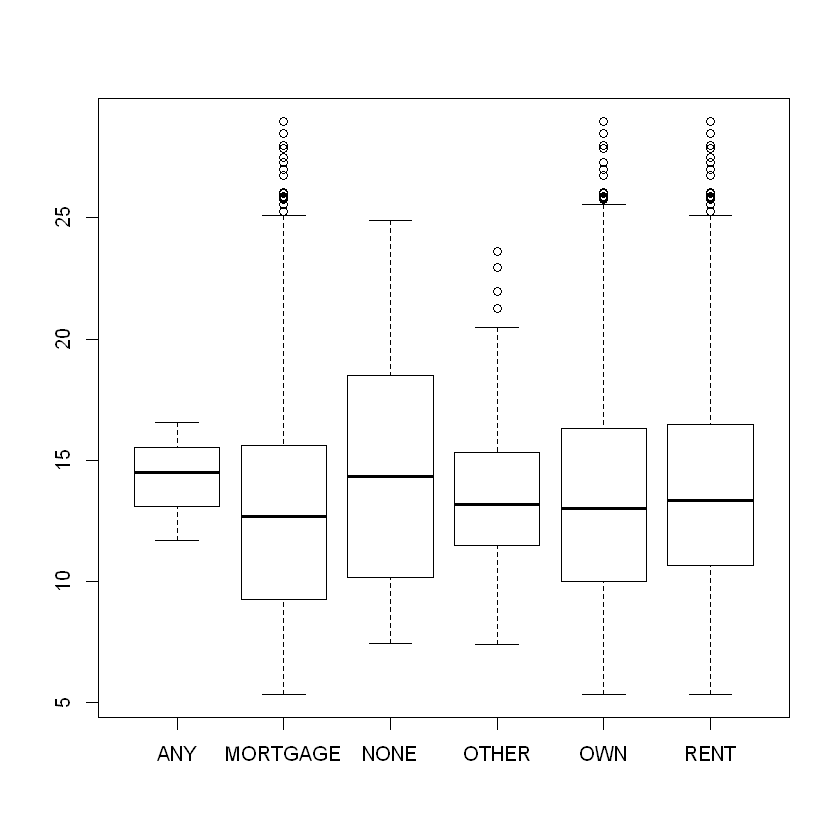

In [10]:
# (1) if level is not too many, we can use bar chart to check the response at different level first
#     and then use t test to compare. Take home_ownership for example. 
boxplot(int_rate ~ home_ownership, loan)

In [11]:
int_state <- by(loan, loan$addr_state, function(x) {
  return(mean(x$int_rate))
  })

In [17]:
quantile(loan$int_rate)

0%   25%   50%   75%  100% 
 5.32  9.99 12.99 16.20 28.99

In [18]:
#collapsing
loan$state_mean_int <- 
  ifelse(loan$addr_state %in% names(int_state)[which(int_state <= 13.08099)],
                              'low',
                              ifelse(loan$addr_state %in% names(int_state)[which(int_state <= 13.28857)],
                                     'medium', 'high'))

In [19]:
#check whether there is informatin reducement
summary(lm(int_rate ~ state_mean_int, loan))


Call:
lm(formula = int_rate ~ state_mean_int, data = loan)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0785 -3.2485 -0.2185  2.8915 16.0717 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          13.398476   0.007396 1811.57   <2e-16 ***
state_mean_intlow    -0.480143   0.017357  -27.66   <2e-16 ***
state_mean_intmedium -0.211998   0.009823  -21.58   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.38 on 887376 degrees of freedom
Multiple R-squared:  0.001064,	Adjusted R-squared:  0.001062 
F-statistic: 472.6 on 2 and 887376 DF,  p-value: < 2.2e-16


In [20]:
#change different category level
loan$state_mean_int <- ifelse(loan$addr_state %in% names(int_state)[which(int_state <= 13.08099)],
                              'low',
                              ifelse(loan$addr_state %in% names(int_state)[which(int_state <= 13.28857)],
                              'low_medium', ifelse(loan$addr_state %in% names(int_state)[which(int_state <= 13.41240)], 
                                                   'medium_high', 'high')))

In [21]:
#check the regression r-square
summary(lm(int_rate ~ state_mean_int, loan))


Call:
lm(formula = int_rate ~ state_mean_int, data = loan)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1995 -3.3492 -0.1965  2.8608 16.0717 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               13.51948    0.01290 1048.39   <2e-16 ***
state_mean_intlow         -0.60115    0.02032  -29.59   <2e-16 ***
state_mean_intlow_medium  -0.33300    0.01442  -23.09   <2e-16 ***
state_mean_intmedium_high -0.18031    0.01574  -11.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.379 on 887375 degrees of freedom
Multiple R-squared:  0.001212,	Adjusted R-squared:  0.001208 
F-statistic: 358.9 on 3 and 887375 DF,  p-value: < 2.2e-16


In [24]:
# Collapsing doesn't only happen to categorical variable, but also to numerical level
loan$inq_last_6mths_cat <- with(loan, ifelse(inq_last_6mths <= 3, as.character(inq_last_6mths),
                                           ifelse(inq_last_6mths <= 10, '3-10', '10+')))
summary(lm(int_rate ~ inq_last_6mths_cat, loan))


Call:
lm(formula = int_rate ~ inq_last_6mths_cat, data = loan)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.7818  -3.2668  -0.1468   2.7825  16.5532 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)            12.436781   0.006035 2060.855   <2e-16 ***
inq_last_6mths_cat1     1.330681   0.010560  126.016   <2e-16 ***
inq_last_6mths_cat10+   0.759839   0.505400    1.503    0.133    
inq_last_6mths_cat2     2.341204   0.015135  154.683   <2e-16 ***
inq_last_6mths_cat3     3.131148   0.022832  137.141   <2e-16 ***
inq_last_6mths_cat3-10  3.665024   0.033830  108.337   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.258 on 887344 degrees of freedom
  (29 observations deleted due to missingness)
Multiple R-squared:  0.05562,	Adjusted R-squared:  0.05562 
F-statistic: 1.045e+04 on 5 and 887344 DF,  p-value: < 2.2e-16


In [23]:
summary(lm(int_rate ~ inq_last_6mths, loan))


Call:
lm(formula = int_rate ~ inq_last_6mths, data = loan)

Residuals:
     Min       1Q   Median       3Q      Max 
-31.3546  -3.3829  -0.2511   2.7571  16.4371 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    12.552878   0.005518  2274.9   <2e-16 ***
inq_last_6mths  0.999086   0.004537   220.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.267 on 887348 degrees of freedom
  (29 observations deleted due to missingness)
Multiple R-squared:  0.05182,	Adjusted R-squared:  0.05182 
F-statistic: 4.85e+04 on 1 and 887348 DF,  p-value: < 2.2e-16


# how do we understand data

In [25]:
head(loan[, c('issue_d', 'last_pymnt_d', 'next_pymnt_d')])

issue_d,last_pymnt_d,next_pymnt_d
Dec-2011,Jan-2015,
Dec-2011,Apr-2013,
Dec-2011,Jun-2014,
Dec-2011,Jan-2015,
Dec-2011,Jan-2016,Feb-2016
Dec-2011,Jan-2015,


In [26]:
# There are "" in the next_pymnt_d, why?

In [28]:
with(subset(loan,next_pymnt_d ==''),table(loan_status))

loan_status
Charged Off  Fully Paid 
      45248      207723 

In [29]:
#it is because the loan_status is charged off or fully paid

In [30]:
with(subset(loan, next_pymnt_d == "" & last_pymnt_d == ""), table(loan_status)) # all charged off

loan_status
Charged Off 
        527 

In [31]:
sub1 <- subset(loan, next_pymnt_d == "" & last_pymnt_d == "") # all charged off
sub2 <- subset(loan, next_pymnt_d == "" & last_pymnt_d != "") # charged off or fully paid
sub3 <- subset(loan, next_pymnt_d != "" & last_pymnt_d == "") # 
sub4 <- subset(loan, next_pymnt_d != "" & last_pymnt_d != "")

In [33]:
with(sub1,table(loan_status))

loan_status
Charged Off 
        527 

In [34]:
with(sub2,table(loan_status))

loan_status
Charged Off  Fully Paid 
      44721      207723 

In [36]:
with(sub3,table(loan_status))

loan_status
                                            Current 
                                               8326 
                                            Default 
                                                  9 
Does not meet the credit policy. Status:Charged Off 
                                                 12 
                                    In Grace Period 
                                                212 
                                             Issued 
                                               8412 
                                  Late (16-30 days) 
                                                 41 
                                 Late (31-120 days) 
                                                120 

In [37]:
with(sub4,table(loan_status))

loan_status
                                            Current 
                                             593453 
                                            Default 
                                               1210 
Does not meet the credit policy. Status:Charged Off 
                                                749 
 Does not meet the credit policy. Status:Fully Paid 
                                               1988 
                                    In Grace Period 
                                               6041 
                                             Issued 
                                                 48 
                                  Late (16-30 days) 
                                               2316 
                                 Late (31-120 days) 
                                              11471 

explore date

In [38]:
library(zoo)
head(loan$issue_d)

Warning message:
"package 'zoo' was built under R version 3.4.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



[1] "Dec-2011" "Dec-2011" "Dec-2011" "Dec-2011" "Dec-2011" "Dec-2011"

In [41]:
loan$issue_d_1 <- as.Date(as.yearmon(loan$issue_d, "%b-%Y"))
loan$issue_year <- format(loan$issue_d_1, '%Y')
loan$issue_mon <- format(loan$issue_d_1, '%m')

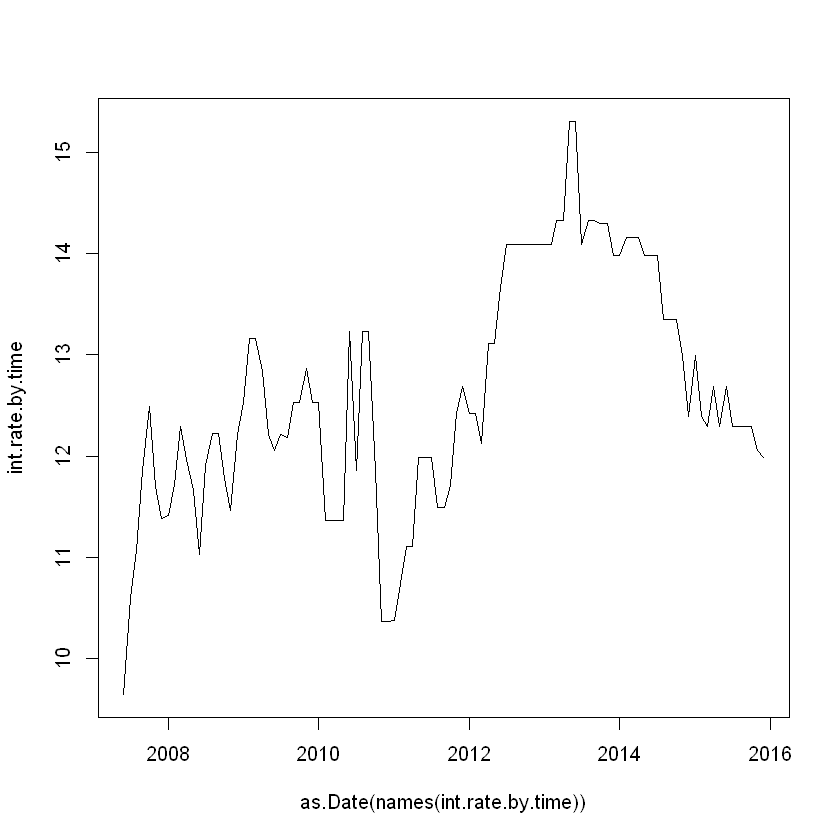

In [42]:
int.rate.by.time <- by(loan, loan$issue_d_1, function(x) {return(median(x$int_rate))})
plot(as.Date(names(int.rate.by.time)), int.rate.by.time, type = 'l')

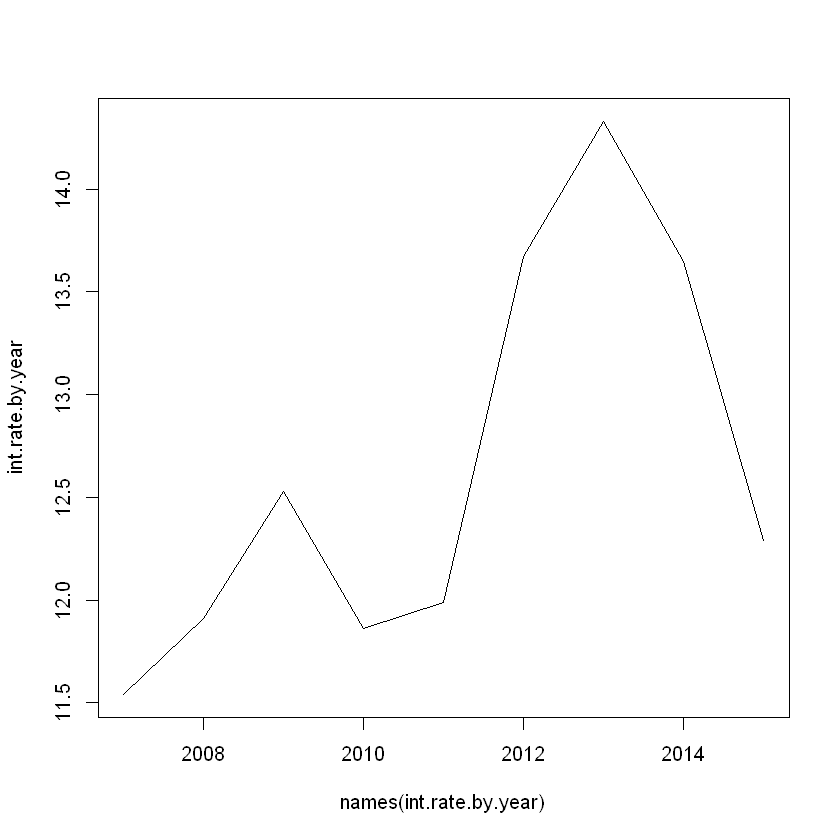

In [43]:
int.rate.by.year <- by(loan, loan$issue_year, function(x) {return(median(x$int_rate))})
plot(names(int.rate.by.year), int.rate.by.year, type = 'l')

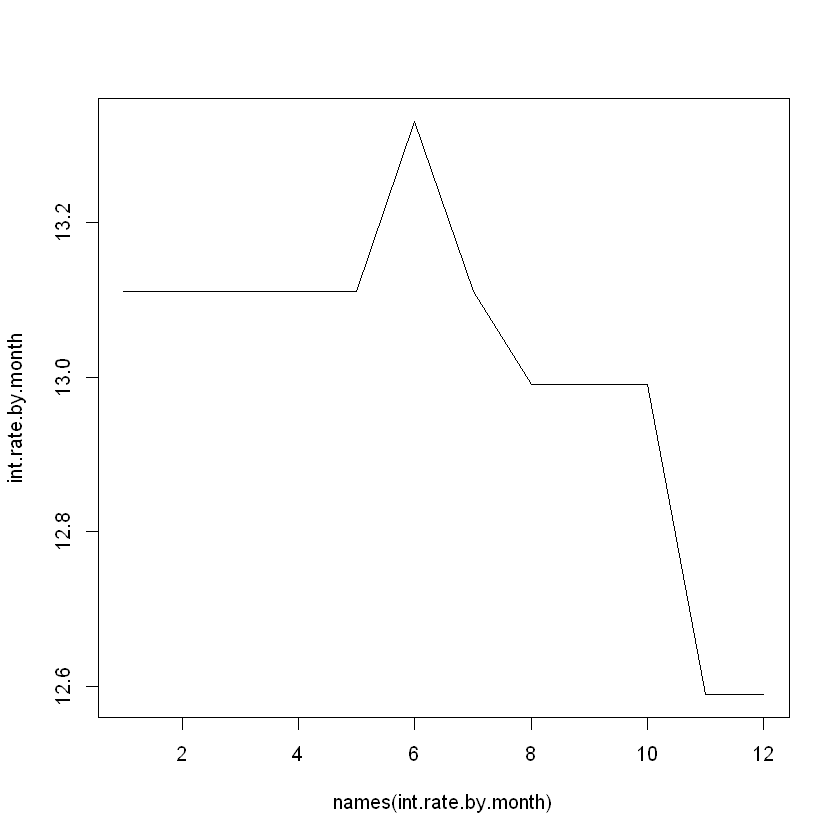

In [44]:
int.rate.by.month <- by(loan, loan$issue_mon, function(x) {return(median(x$int_rate))})
plot(names(int.rate.by.month), int.rate.by.month, type = 'l')

In [46]:
#now we want to see the distribution by times

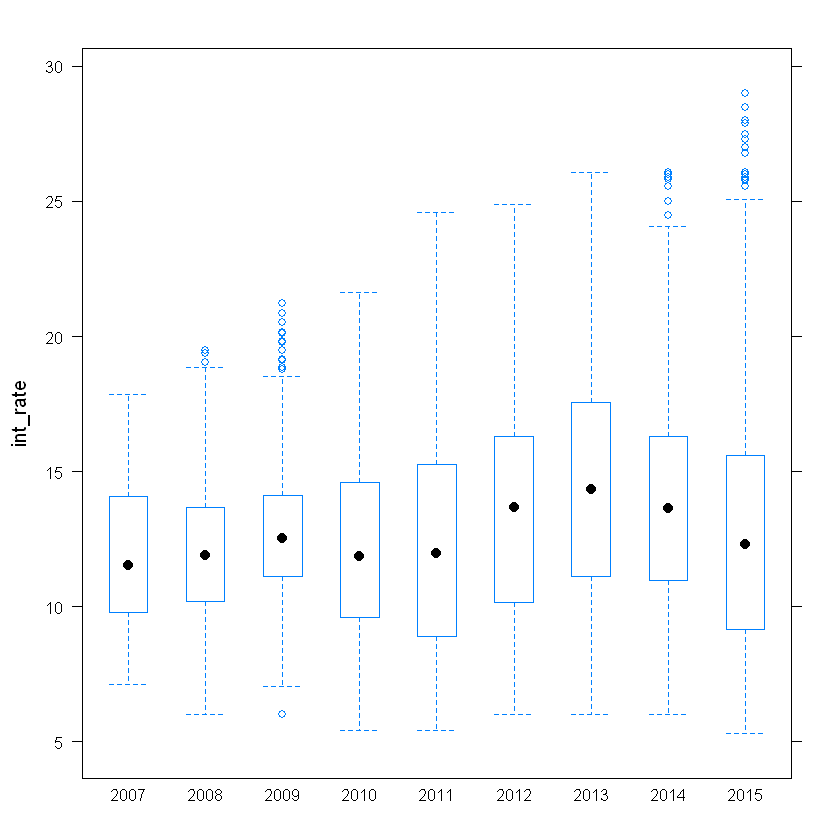

In [45]:
library(lattice)
bwplot(int_rate ~ issue_year, data = loan)

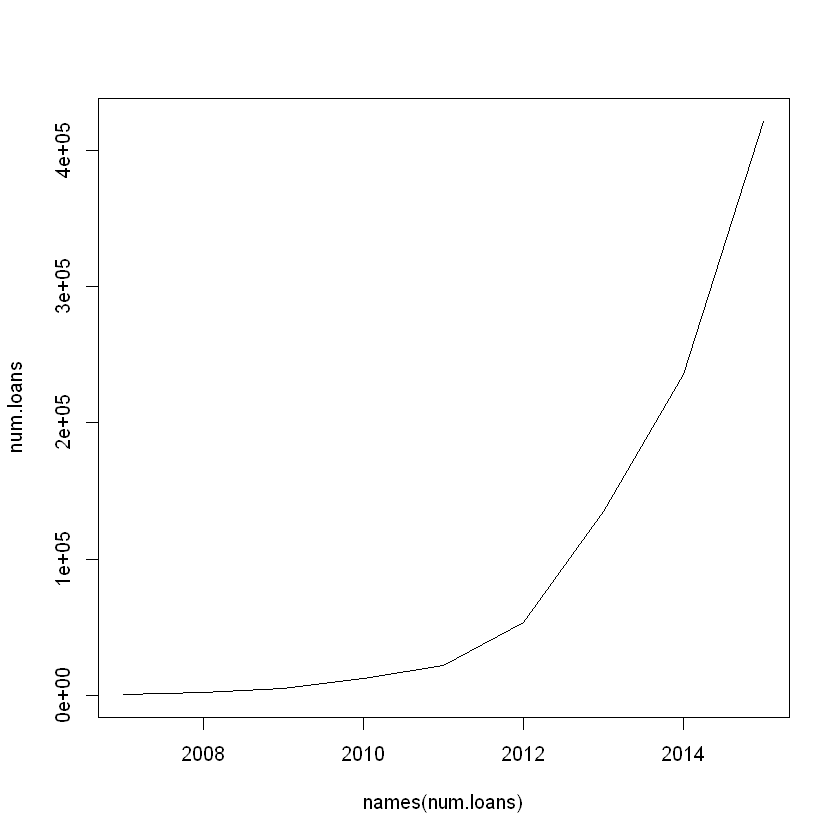

In [47]:
num.loans <- by(loan, loan$issue_year, function(x) {return(dim(x)[1])})
plot(names(num.loans), num.loans, type = 'l')

In [48]:
#the number of loans is increasing by times

In [52]:
loan$issue_d_1 <- as.Date(as.yearmon(loan$issue_d, "%b-%Y"))
loan$next_pymnt_d_1 <- as.Date(as.yearmon(loan$next_pymnt_d, "%b-%Y"))
loan$last_pymnt_d_1 <- as.Date(as.yearmon(loan$last_pymnt_d, "%b-%Y"))
loan$days_since_issue <- as.numeric(with(loan, next_pymnt_d_1 - issue_d_1))
summary(table(loan$days_since_issue)) # so each loan's data is collected at different time point.
loan$months_since_issue <- as.integer(with(loan, next_pymnt_d_1 - issue_d_1)/31)

Number of cases in table: 634408 
Number of factors: 1 

In [53]:
loan$days_two_pymnt <- as.integer(with(loan, next_pymnt_d_1 - last_pymnt_d_1))

In [54]:
table(loan$days_two_pymnt)


     0     28     29     30     31     60     61     62     90     91     92 
 36848    117     29    519 463195     24    395 105418      5     39   3408 
   120    121    122    123    150    151    152    153    181    182    183 
    21     12    345   3042     20     93     13   2514     17     11     10 
   184    212    214    242    243    244    245    273    274    275    276 
  1013     12     25      9      8      6      8      9      2     10      1 
   303    304    306    334    335    365    366    395    396    426    454 
     3     15      1      9      3      8      3      5      2      8      1 
   456    457    487    548    579    609    610    699 
     6      5      3      1      1      1      1      2 

In [56]:
with(subset(loan,days_two_pymnt==699),table(loan_status))#charged off

loan_status
Does not meet the credit policy. Status:Charged Off 
                                                  2 

In [61]:
with(subset(loan,days_two_pymnt==30),table(loan_status))#charged off

loan_status
Does not meet the credit policy. Status:Charged Off 
                                                  2 
 Does not meet the credit policy. Status:Fully Paid 
                                                517 

In [62]:
bad.loan.by.month <- by(loan, loan$months_since_issue, function(x){
  return(dim(subset(x, loan_status %in% c('Charged Off', 'Default', 'Late (16-30 days)',
                                          'Late (31-120 days)')))[1]/dim(x)[1])})

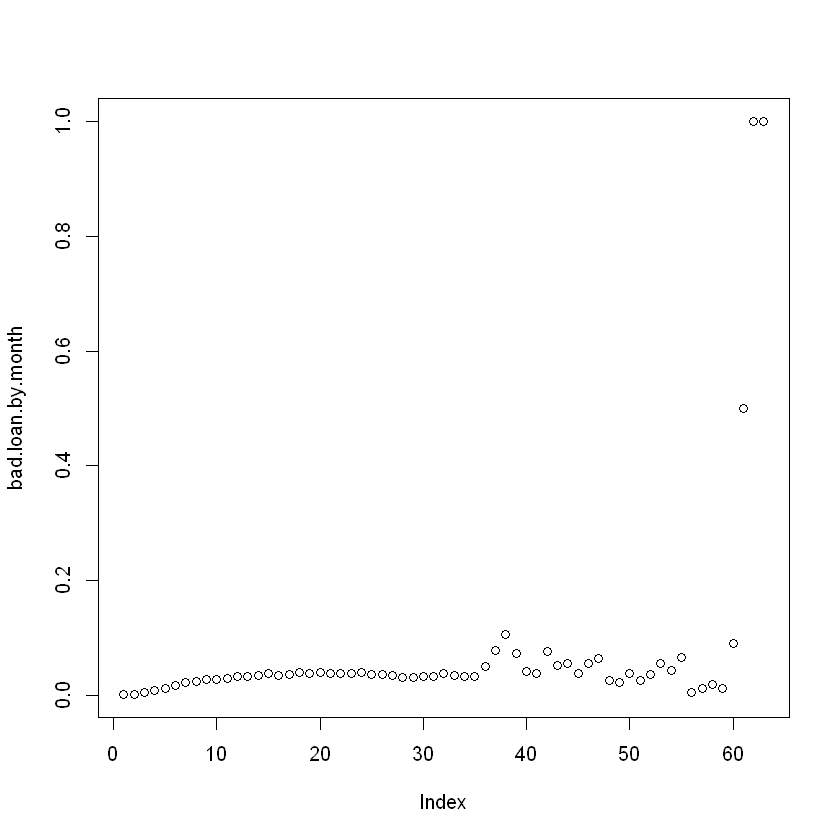

In [63]:
plot(bad.loan.by.month)# At the end, bad loan rate is crazy, why? Data too few, large noise.

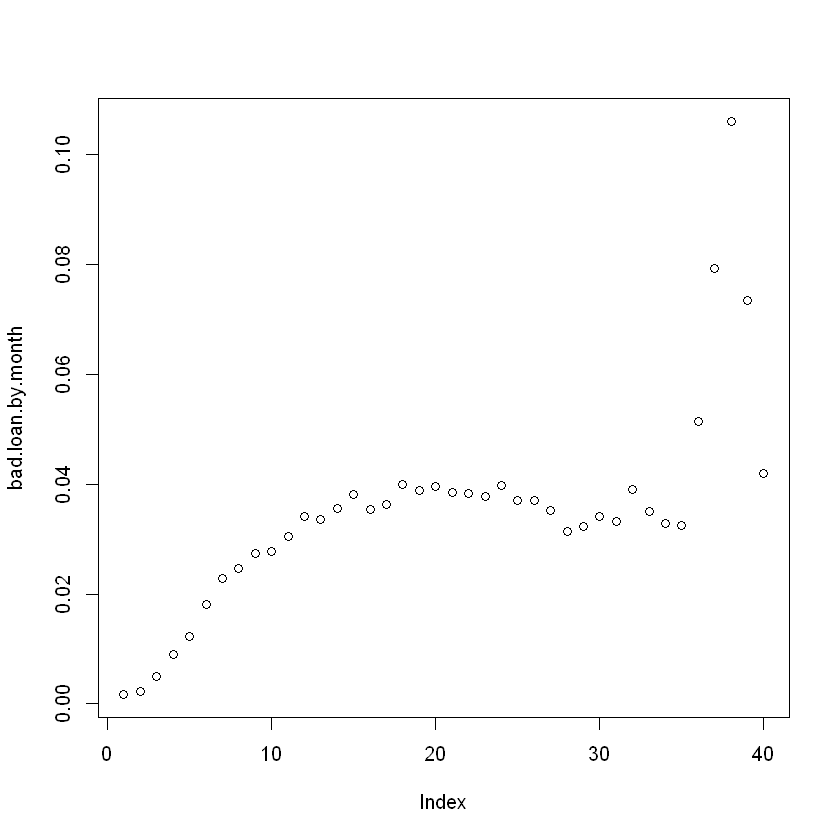

In [66]:
loan$months_since_issue[which(loan$months_since_issue >= 40)] <- 40
bad.loan.by.month <- by(loan, loan$months_since_issue, function(x){
  return(dim(subset(x, loan_status %in% c('Charged Off', 'Default', 'Late (16-30 days)',
                                          'Late (31-120 days)')))[1]/dim(x)[1])})
plot(bad.loan.by.month)

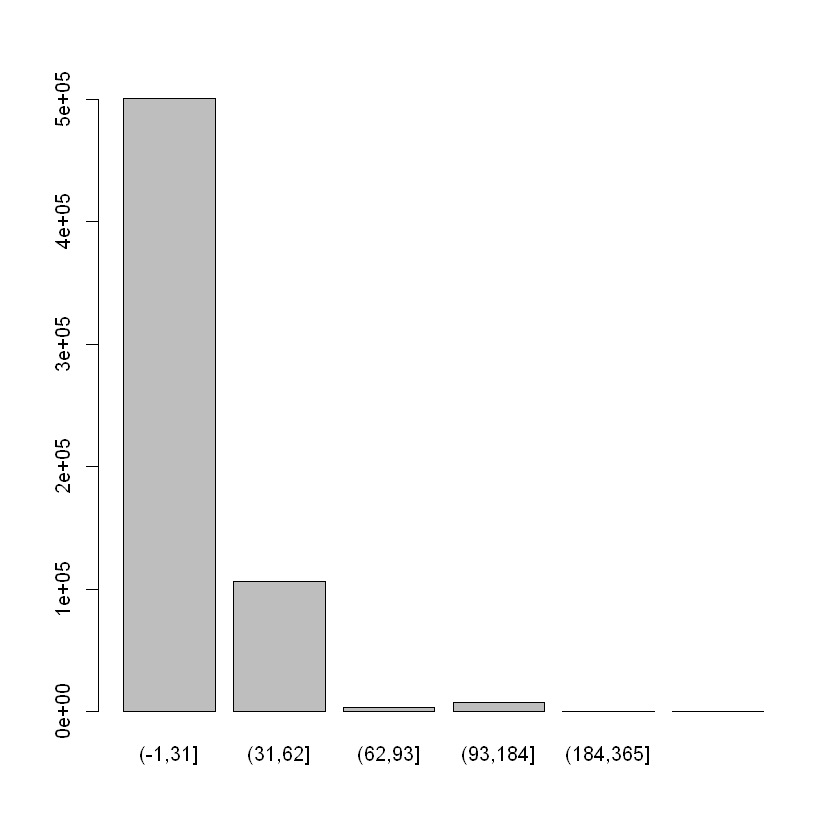

In [67]:
loan$days_btwn_pymnts <- as.numeric(with(loan, next_pymnt_d_1 - last_pymnt_d_1)) # if NA, cuz missing next_pymnt_d
barplot(table(cut(loan$days_btwn_pymnts,
                  breaks = c(-1, 31, 62, 93, 184, 365, 1000))))